In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numdifftools as nd

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from registration_utilities import *
from annotation_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [43]:
v1 = np.zeros((100,100,100))
v1[30:50, :, 40:60] = 1
v1[10:30, :, 40:60] = -1
v1[50:70, :, 40:60] = -1
v1 = np.pad(v1, 50, 'constant', constant_values=0)

v2 = np.zeros((100,100,100))
v2[20:40, 50:, 40:60] = 1
v2[:20, 50:, 40:60] = -1
v2[40:60, 50:, 40:60] = -1
v2[20:40, :50, 40:60] = -1
v2[40:60, :50, 40:60] = 1
v2[60:80, :50, 40:60] = -1
v2 = np.pad(v2, 50, 'constant', constant_values=0)

In [3]:
# v1 = np.zeros((100,100,100))
# v1[30:50, :-40, 40:60] = 1
# v1 = np.pad(v1, 50, 'constant')

# v2 = np.zeros((100,100,100))
# v2[20:40, 40:, 40:60] = 1
# v2 = np.pad(v2, 50, 'constant')

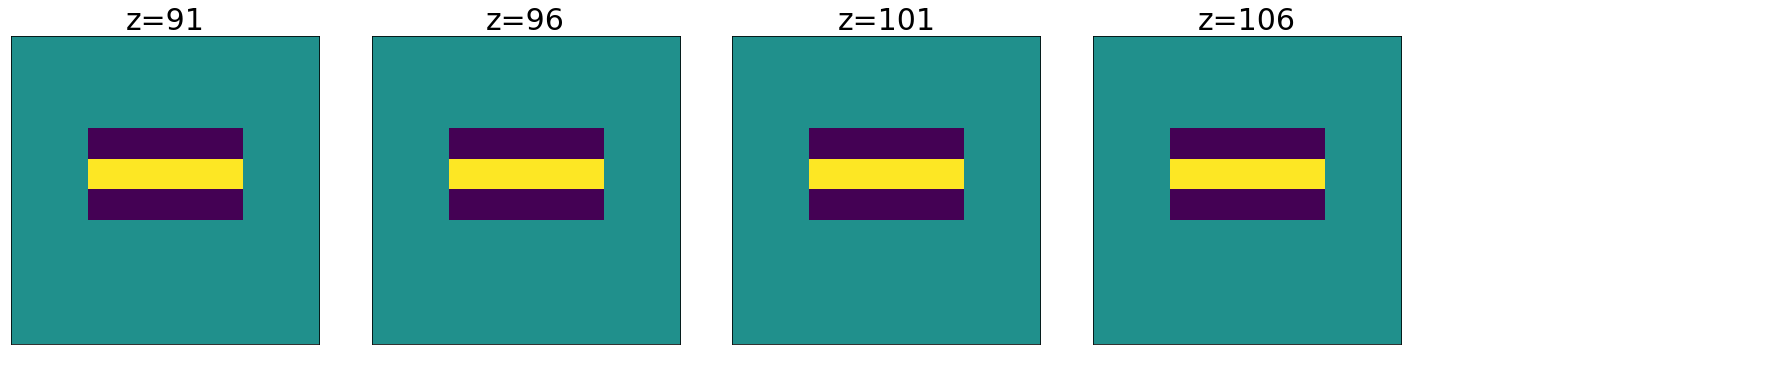

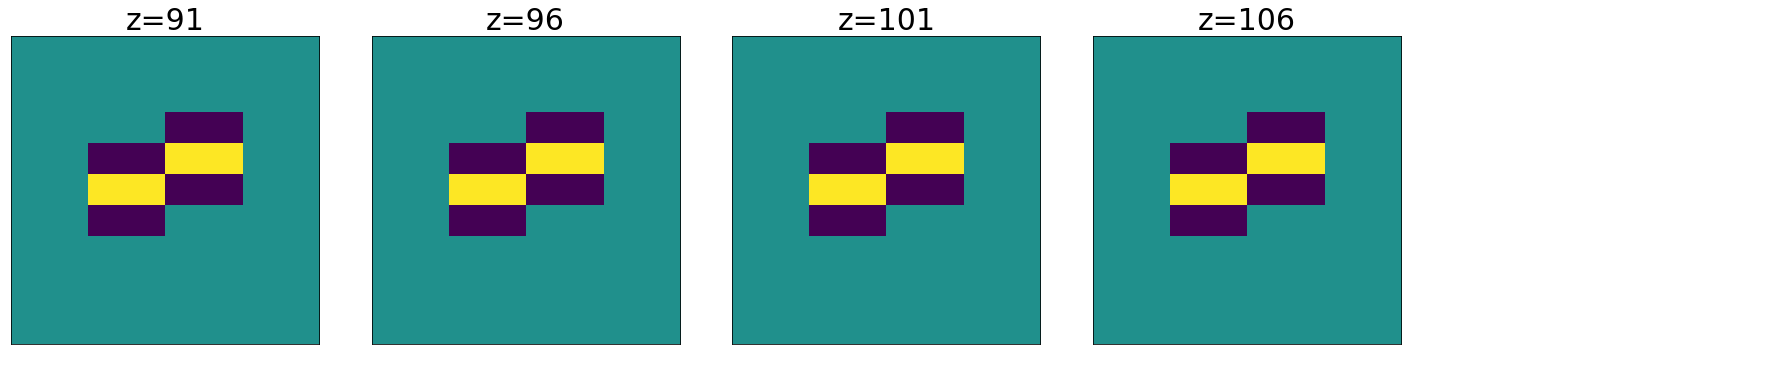

In [44]:
display_volume_sections(v1)
display_volume_sections(v2)

In [45]:
gy1, gx1, gz1 = np.gradient(v1)
gy2, gx2, gz2 = np.gradient(v2)

In [46]:
nz_ys, nz_xs, nz_zs = np.where(v1)
nz_xyzs = np.c_[nz_xs, nz_ys, nz_zs]
n_nz = len(nz_xs)

# Phi = np.c_[np.ones((n_nz,)), nz_xs, nz_ys, nz_zs]

In [47]:
A = np.array([v1[y,x,z] for x,y,z in nz_xyzs])

In [48]:
ctrl_ys, ctrl_xs, ctrl_zs = np.meshgrid(np.arange(0, 100, 10), np.arange(0, 100, 10), np.arange(0, 100, 10))
ctrl_xyzs = np.c_[ctrl_xs.flatten(), ctrl_ys.flatten(), ctrl_zs.flatten()]
n_ctrl = len(ctrl_xyzs)

In [49]:
Kappa_ctrlPts = np.array([np.linalg.norm(ctrl_xyzs - p, axis=1) for p in ctrl_xyzs])

In [52]:
lr = 1e-4

In [ ]:
Wx = np.zeros((n_ctrl,))
Wy = np.zeros((n_ctrl,))
Wz = np.zeros((n_ctrl,))

dCdWx_historical = 0
dCdWy_historical = 0
dCdWz_historical = 0

for iteration in range(100):
    print iteration

    r = np.array([np.linalg.norm(ctrl_xyzs - p, axis=1) for p in nz_xyzs])

    Kappa = r

    q = nz_xyzs + np.dot(Kappa, np.c_[Wx, Wy, Wz])

    ###################################
    
    S = np.array([v2[int(y), int(x), int(z)] for x,y,z in q])
    F = np.dot(A, S) - np.dot(Wx.T, np.dot(Kappa_ctrlPts, Wx)) - \
    np.dot(Wy.T, np.dot(Kappa_ctrlPts, Wy)) - \
    np.dot(Wz.T, np.dot(Kappa_ctrlPts, Wz))
    print F
    
#     grid_points = [(x,y,100) for x in range(0,v1.shape[1],2) for y in range(0,v1.shape[0],2)]
#     dist_to_ctrl = np.array([np.linalg.norm(ctrl_xyzs - p, axis=1) for p in grid_points])
#     u = dist_to_ctrl
#     warped_grid_points = grid_points + np.dot(u, np.c_[Wx, Wy, Wz])
    
#     plt.scatter(warped_grid_points[:,0], warped_grid_points[:,1], s=2)
#     plt.show()
    
    #####################################
    
    dSdq_allTestPts = np.array([(gx2[y,x,z], gy2[y,x,z], gz2[y,x,z]) for x,y,z in q.astype(np.int)])

    dqxdWx = Kappa
    dqydWy = Kappa
    dqzdWz = Kappa

    dSdWx_allTestPts = dSdq_allTestPts[:,0][:,None] * dqxdWx
    dSdWy_allTestPts = dSdq_allTestPts[:,1][:,None] * dqydWy
    dSdWz_allTestPts = dSdq_allTestPts[:,2][:,None] * dqzdWz

    dFdWx = np.dot(A, dSdWx_allTestPts)
    dFdWy = np.dot(A, dSdWy_allTestPts)
    dFdWz = np.dot(A, dSdWz_allTestPts)

    dQdWx = 2*np.dot(Kappa_ctrlPts, Wx)
    dQdWy = 2*np.dot(Kappa_ctrlPts, Wy)
    dQdWz = 2*np.dot(Kappa_ctrlPts, Wz)
    
    gamma = 0
    
    dCdWx = dFdWx - gamma * dQdWx
    dCdWy = dFdWy - gamma * dQdWy
    dCdWz = dFdWz - gamma * dQdWz
    
    # AdaGrad Rule
    dCdWx_historical += dCdWx**2
    dCdWy_historical += dCdWy**2
    dCdWz_historical += dCdWz**2
    
    dCdWx_adjusted = dCdWx / np.sqrt(dCdWx_historical + 1e-10)
    dCdWy_adjusted = dCdWy / np.sqrt(dCdWy_historical + 1e-10)
    dCdWz_adjusted = dCdWz / np.sqrt(dCdWz_historical + 1e-10)
    
    Wx = Wx + lr * dCdWx_adjusted
    Wy = Wy + lr * dCdWy_adjusted
    Wz = Wz + lr * dCdWz_adjusted
    
    ###############################
    
#     nzvoxels_m_temp = parallel_where_binary(v1 > 0)

#     dist_to_ctrl = np.array([np.linalg.norm(ctrl_xyzs - p, axis=1) for p in nz_xyzs])
#     u = dist_to_ctrl
#     nzs_m_aligned_to_f = (nz_xyzs + np.dot(u, np.c_[Wx, Wy, Wz])).astype(np.int)

#     ydim_f, xdim_f, zdim_f = v2.shape

#     volume_m_aligned_to_f = np.zeros(v2.shape, v1.dtype)

#     xs_f, ys_f, zs_f = nzs_m_aligned_to_f.T

#     valid = (xs_f >= 0) & (ys_f >= 0) & (zs_f >= 0) & \
#     (xs_f < xdim_f) & (ys_f < ydim_f) & (zs_f < zdim_f)

#     xs_m, ys_m, zs_m = nz_xyzs.T

#     volume_m_aligned_to_f[ys_f[valid], xs_f[valid], zs_f[valid]] = \
#     v1[ys_m[valid], xs_m[valid], zs_m[valid]]

#     del nzs_m_aligned_to_f

#     if np.issubdtype(volume_m_aligned_to_f.dtype, np.float):
#         dense_volume = fill_sparse_score_volume(volume_m_aligned_to_f)
#     elif np.issubdtype(volume_m_aligned_to_f.dtype, np.integer):
#         dense_volume = fill_sparse_volume(volume_m_aligned_to_f)
#     else:
#         raise Exception('transform_volume: Volume must be either float or int.')
    
#     display_images_in_grids([v1[..., 100], v2[..., 100], dense_volume[..., 100]],
#                         nc=3, titles=['moving', 'fixed', 'deformed moving'],
#                        cmap=plt.cm.gray, vmin=0, vmax=1)
    
    ###################################